# ML pipeline: Binary Classification 

##  <font color='blue'>General protocol - comparing algorithms</font>

C Fanara, October 2021

binary classif_v1.2b.ipynb
____________________________________________________________
### 1.Introduction
We use several binary classifiers for benchmark purposes.

In this version the modeling step is iterated 'k' times (k is selectable) for the Scikit learn algorithms

(Upd july 2021: added _xgboost_)

For now, we do data exploration and visualization, specifically to clean the data before modeling, however, this part will be moved to a differnt module in the pipeline. 

Also for now, we focus on the algos as applied to an individual dataset, typically for the dev of a use case, but for extensive bench tasks, it will be put into an autoML solution to test the several hundreds of datasets (like Penn and UCI collections)

#### This problem
75 predictor variables, 'age', 'sex','smoker or not' etc, and target variable: presence (1) / absence  (0) of heart disease
Note, the UCI dataset link: https://archive.ics.uci.edu/ml/datasets/Heart+Disease
The main paper: _Detrano, R., Janosi, A., Steinbrunn, W., Pfisterer, M., Schmid, J., Sandhu, S., Guppy, K., Lee, S., & Froelicher, V. (1989). International application of a new probability algorithm for the diagnosis of coronary artery disease. American Journal of Cardiology, 64,304--310
Some meaning - see appendix for the data dictionary_ (web link at UCI not working
Also note the study at: https://towardsdatascience.com/heart-disease-uci-diagnosis-prediction-b1943ee835a7
_____________________________________________________________
Feb 2021; 
rev. v 0.5 jun 2021, v 0.9 jul 2021, v 1.0 sept 2021
v. 1.2 October 2021 (shap)


<font color='green'>See Todo's list at end</font>
_____________________________________________________________


### 2.Library imports

**Note:** code might be retrieved from the corresponding gitlab project. 

In [68]:
import sys, os
import time

import pandas as pd
from pandas import Series
import numpy as np
from sklearn.preprocessing import label_binarize

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff

import math  # useful for float NaN
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

import xgboost as xgb
import catboost as ctb
from catboost import CatBoostRegressor, Pool, cv

from sklearn.metrics import (accuracy_score, recall_score, f1_score, roc_auc_score, confusion_matrix, matthews_corrcoef, precision_score)
from xgboost import XGBClassifier,plot_importance

# roc and related
from scipy import interp
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve

# Ipython display facilities
from IPython.display import HTML, display
import tabulate

# interpretation
import shap




### 3.Data - import and look
Import DataSet to Panda's DataFrame + quick EDA

In [14]:
# might ask filename with interactive  UI
namef='heart.csv' # the bare name

# read csv using pandas
df = pd.read_csv('~/Documents/Infra_py-ML/classif_data/heart.csv')

# display basic information about the dataframe
print('Dataframe\'s shape: {}\n'.format(df.shape))

# for later (write at the end)
tsk='BiCl'  # others might be: "MuCl"=Multi-class; "Regr"=Regression

df.info()
# describe numeric columns
# df.describe()

Dataframe's shape: (303, 14)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [15]:
df.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


In [16]:
df['target'].value_counts()  # check data balance for target

1    165
0    138
Name: target, dtype: int64

array([[<AxesSubplot:title={'center':'target'}>]], dtype=object)

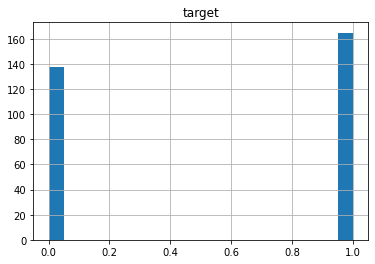

In [17]:
# just to viz it
df.hist(column=df.columns[-1], bins=20)


### 4.Data Profiling 

In [6]:
# Quick EDA using panda profiling
from pandas_profiling import ProfileReport
profile_heart = ProfileReport(df, title="heart.csv data" )
profile_heart

Summarize dataset:   0%|          | 0/27 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [18]:
### some NaN,possibly? leave commented if previous EDA says 0
# df.isnull().sum(axis = 1)

# visual map Na's
# if any, visualize those
# sns.heatmap(df.isnull(), cbar=False)

# or this
# sum([True for idx,row in df2.iterrows() if any(row.isnull())]) # counts null rows 

# df2.isnull().values.ravel().sum()  # counts the total of null cells

# alternative - extensive:
#for col in df:
#    print (df[col].value_counts(dropna=False))
# print(df[df['12s_60_or_15s'].isnull()])
# df = df.dropna(subset=['<specify var or ocndition>'])

# or drastic!
# df_clean = df.dropna()

### 5.Modeling

#### 5.1 Prepare data

In [19]:
# Prepare training and test sets
target = 'target'

features = df.columns.tolist()
features.remove(target)
print(features, len(features), target)


['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal'] 13 target


In [20]:
# Note: may want to check this. else rename as done in other regression script, as below:
X = df[features]
y = df[target]

print(X.shape, y.shape)


(303, 13) (303,)


#### 5.2 Standardization / Normalization

Several choices here.
Standard scaler assumes normality - from EDA we know it is not nec te case for the features , hence a more 'neutral min - max could be used:
df_norm = (df-df.min())/(df.max()-df.min())
___________________________________
technically one may observe:
One way is to use a transformer, where the standardiation is a 'parameter' and the chosen columns are indicated, the rest being unaltered:

In [21]:
X_norm = (X-X.min())/(X.max()-X.min())

In [22]:
X=X_norm
#X.info()

In [23]:
# note, the following could be used in the EDA as well:
# https://docs.dataprep.ai/user_guide/user_guide.html

#from dataprep.eda import plot
#from dataprep.eda import plot_correlation
#from dataprep.eda import plot_missing
#plot_correlation(df, "price", value_range=[0.2, 1])  # select correlation threshold


### 6.Feature Importance

#### 6.1 Run selected algorithms
- Random Forest
- xgboost
- catboost (not now)


We also instantiate them in the multi-model protocol 

NB here we hacve all floating variables, despite being a binary problem, hemce we can try regressors...
Discuss


In [24]:
# define the function Feature importance
def plot_feature_importance(importance,names,model_type):

    # Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    # Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    # Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    # Define size of bar plot
    plt.figure(figsize=(10,8))
    # Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    # Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')


In [26]:
# split to perform the fit for the two models below
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=np.random.RandomState(seed=None))  # shuffled but not stratified
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 212 entries, 152 to 220
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       212 non-null    float64
 1   sex       212 non-null    float64
 2   cp        212 non-null    float64
 3   trestbps  212 non-null    float64
 4   chol      212 non-null    float64
 5   fbs       212 non-null    float64
 6   restecg   212 non-null    float64
 7   thalach   212 non-null    float64
 8   exang     212 non-null    float64
 9   oldpeak   212 non-null    float64
 10  slope     212 non-null    float64
 11  ca        212 non-null    float64
 12  thal      212 non-null    float64
dtypes: float64(13)
memory usage: 23.2 KB


In [19]:
# fit train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=np.random.RandomState(seed=None))  # shuffled but not stratified
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 212 entries, 286 to 96
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       212 non-null    float64
 1   sex       212 non-null    float64
 2   cp        212 non-null    float64
 3   trestbps  212 non-null    float64
 4   chol      212 non-null    float64
 5   fbs       212 non-null    float64
 6   restecg   212 non-null    float64
 7   thalach   212 non-null    float64
 8   exang     212 non-null    float64
 9   oldpeak   212 non-null    float64
 10  slope     212 non-null    float64
 11  ca        212 non-null    float64
 12  thal      212 non-null    float64
dtypes: float64(13)
memory usage: 23.2 KB


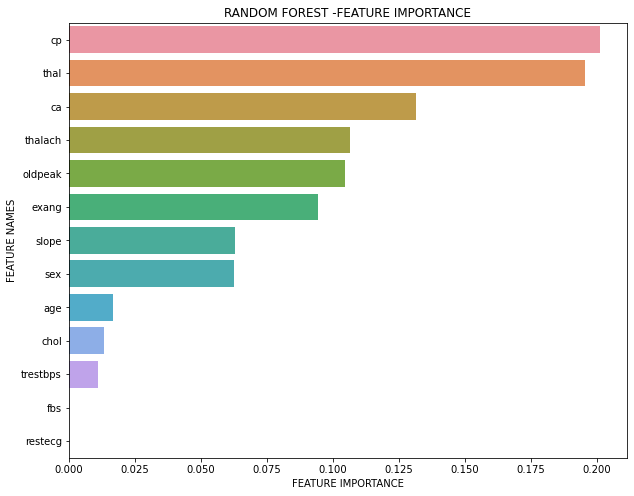

In [27]:
# rf first
RFclf=RandomForestClassifier(max_depth=2, random_state=0)
RFclf.fit(X_train,y_train)

# call it
plot_feature_importance(RFclf.feature_importances_, X_train.columns,'RANDOM FOREST -')

#### Warning: inconsistency between libraries outcome

[16:52:55] WARNING: ../src/learner.cc:573: 
Parameters: { "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:52:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


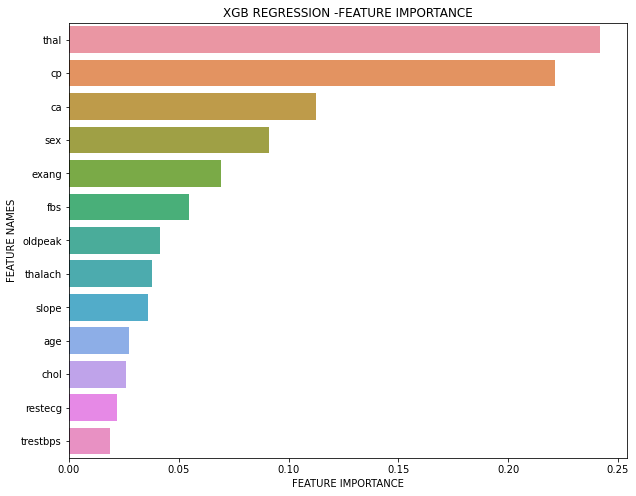

In [28]:
# XGboost
# note the comments on hyperparams: https://www.datacamp.com/community/tutorials/xgboost-in-python
# obj= loss function for regression, colsample_bytree =% features per tree
# learning_rate: step size shrinkage used to prevent overfitting.
# alpha=L1 regularization on leaf weights

XGBclf = XGBClassifier(use_label_encoder=False, metric='error').fit(X_train, y_train)

# call it
plot_feature_importance(XGBclf.feature_importances_, X_train.columns,'XGB REGRESSION -')

[16:54:11] WARNING: ../src/learner.cc:573: 
Parameters: { "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:54:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

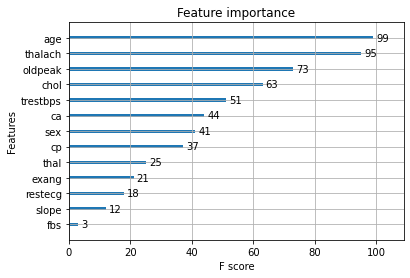

In [31]:
# as a check  - used tow different plotters with different results - lookout for warning on encoder (?) and metrics (?)
XGBclf= XGBClassifier(use_label_encoder=False, metric='logloss').fit(X_train,y_train)
plot_importance(XGBclf)
# plot_feature_importance(XGBclf.feature_importances_, X_train.columns,'XGB REGRESSION -')

#### 6.2 Decide 
1. whether to drop variables here or do some RFE
2. the two var imp plots, same classififer, different plotting, give **radically different** plots - who's right?
(This is just the general protocol - worth re-looking at the more generas issues within the large topic of Feature engineering..)

### 7. Generalized train

#### 7.1 defining metrics

In [ ]:
## CatBoost
## note, from link:
## https://catboost.ai/en/docs/installation/r-installation-conda-install
## it is stated GPU support "out of the box"
## NB this method is useful for using categorical variables! Hence useful to preserve categorical var and use it for mixed cases

#CATregr = CatBoostRegressor(iterations=50, loss_function='RMSE', max_depth=2, random_state=0)
#CATregr.fit(X_train, y_train)

## call it
#plot_feature_importance(CATregr.feature_importances_, X_train.columns,'CATBOOST REGRESSION -')

In [35]:
# Generic all-in-one function to train an sklearn estimator and return the corresponding metrics for the training and test sets
#
def plot_and_compute_classification_metrics(name, estimator, X_train, y_train, X_test, y_test, display_plots=False):
       
    
    start = time.time()
    # Train model
    estimator.fit(X_train, y_train)
    stop = time.time()
    exec_t=stop - start
    
    # Compute classif metrics for both training and test data
    train_predictions = estimator.predict(X_train)
    train_accuracy = accuracy_score(y_train, train_predictions) 
    train_precision = precision_score(y_train, train_predictions)
    train_recall = recall_score(y_train, train_predictions)
    train_f1 = f1_score(y_train, train_predictions)
    train_mcc = matthews_corrcoef(y_train, train_predictions)

    test_predictions = estimator.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_predictions) 
    test_precision = accuracy_score(y_test, test_predictions) 
    test_recall = recall_score(y_test, test_predictions) 
    test_f1 = f1_score(y_test, test_predictions)
    test_mcc = matthews_corrcoef(y_test, test_predictions)

    return train_accuracy, train_precision, train_recall, train_f1, train_mcc, test_accuracy, test_precision, test_recall, test_f1, test_mcc, exec_t


#### 7.2 sklearn training models (classifier/s)

In [36]:
# Instantiate sklearn binary classification estimators. Worth modifying per case.

# NB xgboost canbe used as a multicclass on its own, setting appropriate parameters. see: 
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
# Also xgboost can be applied with the scikit learn wrapper: XGBoost
# run a script on xgb alone to learn the parameters as in  link above

# predict_proba method can be directly interpreted as a confidence level and logistic regr does because it optimizes log-loss
# LogisticRegression - https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
#logreg = LogisticRegression(random_state=0, max_iter=50).fit(X, y) # --> mystery error on iter even if did not run yet?!
logreg = LogisticRegression(C=1, penalty='l1', tol=0.01, solver='saga')

# KNearestNeighbors -  https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
knn = KNeighborsClassifier(3) 

# Linear SVM  -  https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html NB kernel parameter, among others - as in the ff rbf
lsvm = SVC(kernel="linear", C=0.025)

# RBF SVM - https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html NB kernel parameter, among others
rbfsvm = SVC(gamma=2, C=1)

# GaussianProcess   - https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessClassifier.html
gp = GaussianProcessClassifier(1.0 * RBF(1.0))   

# Decision Tree - https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
tree = DecisionTreeClassifier(max_depth=5) 

# Random Forest - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
forest = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)

# Neural network - https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
neural_net = MLPClassifier(alpha=1)

# Ada Boost - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
ada_boost = AdaBoostClassifier()

# Naive Bayes - https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html
naive_bayes = GaussianNB()

# QDA- https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis.html
qda = QuadraticDiscriminantAnalysis()

# xgb_model = XGBClassifier(learning_rate =0.1,
#n_estimators=1000, max_depth=6, min_child_weight=1, gamma=0.5, subsample=0.8, colsample_bytree=0.3, objective= 'binary:logistic', nthread=4, scale_pos_weight=1)

# use same parameters as in variable importance
xgb_model = XGBClassifier(use_label_encoder=False, metric='error')

estimators = {
    "LogisticRegression":logreg,
    "KNearestNeighbors": knn,
    #"LinearSVM": lsvm,
    #"RBFSVM": rbfsvm,
    "GaussianProcess": gp,
    "Decision Tree": tree,
    "Random Forest": forest,
    #"Neural network": neural_net,
    #"Ada Boost": ada_boost,
    #"Naive Bayes": naive_bayes,
    #"QDA": qda,
    "XGBoost":xgb_model
}


#### 7.2 Run Training routines
Iterating over all the models k-times
May want to run several times with different k so to have the tables.  

In [38]:
# Measure also exec time? not easy/precise? in jupyter

k = 5   # several files were run with 2, 5, 10, 15, 20. Standard is 10 - worth experimenting
# caution, loop ends at k-1 and here it starts from 1, so need k+1 iteration!

# def header of table out of loop.
#metrics = [["repetition", "Estimator", "Train Acc", "Train Precision", "Train Recall", "Train F1", "Train MCC", 
#           "Test Acc", "Test Precision", "Test Recall", "Test F1", "Test MCC", "Train time"]]

metrics = [["Estimator", "Train Acc", "Train Precision", "Train Recall", "Train F1", "Train MCC", 
           "Test Acc", "Test Precision", "Test Recall", "Test F1", "Test MCC", "Train time"]]

# first element, 0, is header and loop ends at high end -1 so, use k+1
for i in range(1, k+1):           
    
    # avoid identical results by changing seed for each repetition of the lot (take k)
    # np.random.seed(None).
  
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=np.random.RandomState(seed=None))  # shuffled but not stratified
    # Train, predict and compute metrics for each estimator 
   
    
    for name, estimator in estimators.items():
        print("Current estimator: {}".format(name))
        print (i)
        # tuple added as a list to the table
        trn_acc, trn_prec, trn_rec, trn_f1, trn_mcc, tst_acc, tst_prec, tst_rec, tst_f1, tst_mcc, trn_time = plot_and_compute_classification_metrics(name, estimator, X_train, y_train, X_test, y_test)
      
        # metrics.append([name, estimator, trn_acc, trn_prec, trn_rec, trn_f1, trn_mcc, tst_acc, tst_prec, tst_rec, tst_f1, tst_mcc ]) 
        # metrics.append([i, name, trn_acc, trn_prec, trn_rec, trn_f1, trn_mcc, tst_acc, tst_prec, tst_rec, tst_f1, tst_mcc, trn_time ]) 
        metrics.append([name, trn_acc, trn_prec, trn_rec, trn_f1, trn_mcc, tst_acc, tst_prec, tst_rec, tst_f1, tst_mcc, trn_time ])
        
        #print(i)
        #print(trn_acc)
        # metrics.append([name, *(plot_and_compute_classification_metrics(name, estimator, X_train, y_train, X_test, y_test))])
    
    
    # issue about too many open windows? for now, brutally close current - or all - window/s
    # plt.close() # current window
    # plt.close('all')  # all open figures.    
       


# finished estimator loop and the number of times (k) loop, so 
# 1. may want to see global table for debugging:
#display(HTML(tabulate.tabulate(metrics, tablefmt='html', headers='firstrow')))

# 2. append to dataframe then group by - metr_df is the dataframe for the global stats
#metr_df = pd.DataFrame(metrics[1:], columns=["Repetition","Estimator", "Train Acc", "Train Precision", "Train Recall", "Train F1", "Train MCC", 
 #           "Test Acc", "Test Precision", "Test Recall", "Test F1", "Test MCC", "Train time"])     
metr_df = pd.DataFrame(metrics[1:], columns=["Estimator", "Train Acc", "Train Precision", "Train Recall", "Train F1", "Train MCC", 
            "Test Acc", "Test Precision", "Test Recall", "Test F1", "Test MCC", "Train time"])     

Current estimator: LogisticRegression
1
Current estimator: KNearestNeighbors
1
Current estimator: GaussianProcess
1
Current estimator: Decision Tree
1
Current estimator: Random Forest
1
Current estimator: XGBoost
1
[16:55:38] WARNING: ../src/learner.cc:573: 
Parameters: { "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:55:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Current estimator: LogisticRegression
2
Current estimator: KNearestNeighbors
2
Current estimator: GaussianProcess
2


Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


Current estimator: Decision Tree
2
Current estimator: Random Forest
2
Current estimator: XGBoost
2
[16:55:39] WARNING: ../src/learner.cc:573: 
Parameters: { "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:55:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


Current estimator: LogisticRegression
3
Current estimator: KNearestNeighbors
3
Current estimator: GaussianProcess
3
Current estimator: Decision Tree
3
Current estimator: Random Forest
3
Current estimator: XGBoost
3
[16:55:39] WARNING: ../src/learner.cc:573: 
Parameters: { "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:55:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Current estimator: LogisticRegression
4
Current estimator: KNearestNeighbors
4


Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


Current estimator: GaussianProcess
4
Current estimator: Decision Tree
4
Current estimator: Random Forest
4
Current estimator: XGBoost
4
[16:55:40] WARNING: ../src/learner.cc:573: 
Parameters: { "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:55:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Current estimator: LogisticRegression
5
Current estimator: KNearestNeighbors
5
Current estimator: GaussianProcess
5

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



Current estimator: Decision Tree
5
Current estimator: Random Forest
5
Current estimator: XGBoost
5
[16:55:40] WARNING: ../src/learner.cc:573: 
Parameters: { "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:55:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


In [39]:
# Gather metrics in a common table
#display(HTML(tabulate.tabulate(metrics, tablefmt='html', headers='firstrow')))

#### 7.3 Grouping estimators ###

In [40]:
#metr_df.head(25) # 18, just to check for repetitions

In [41]:
# group by estimator and stats (avg of the 4 error columns)- aggregation procedure out of groupby operation
aggregations = {
    'Train Acc':'mean', 
    'Train Precision':'mean', 
    'Train Recall':'mean', 
    'Train F1':'mean', 
    'Train MCC':'mean',           
    'Test Acc':'mean', 
    'Test Precision':'mean', 
    'Test Recall':'mean', 
    'Test F1':'mean', 
    'Test MCC':'mean',
    'Train time': 'mean'
}

# Generate the aggregated metric dataframe
#estim_stats=metr_df.groupby('Estimator', as_index=False).agg(aggregations) # 'as_index': to preserve column in dataframe
estim_stats=metr_df.groupby('Estimator').agg(aggregations) # column in dataframe is estimator without the number


#### 7.4 Metrics: overall results comparison
final table (sorted by Test Accuracy)

In [42]:
#estim_stats

In [43]:
## k-averages of previous tables, sorted by Accuracy. If we want to use other metrics or exec time: sort it accordingly
estim_stats.sort_values(by="Test Acc", ascending=False, inplace=True)

display(HTML(tabulate.tabulate(estim_stats, tablefmt='html', headers=metrics[0])))

Estimator,Train Acc,Train Precision,Train Recall,Train F1,Train MCC,Test Acc,Test Precision,Test Recall,Test F1,Test MCC,Train time
GaussianProcess,0.883962,0.872555,0.919355,0.895245,0.766629,0.826374,0.826374,0.897885,0.852473,0.648149,0.241091
LogisticRegression,0.85283,0.834919,0.907417,0.869598,0.704325,0.817582,0.817582,0.910352,0.848268,0.632026,0.0044919
Random Forest,0.916038,0.907532,0.941898,0.923859,0.831984,0.806593,0.806593,0.873583,0.833794,0.605757,0.018504
XGBoost,1,1,1,1,1,0.804396,0.804396,0.877141,0.8333,0.600628,0.0757173
KNearestNeighbors,0.890566,0.891019,0.9091,0.899728,0.779714,0.797802,0.797802,0.859495,0.825777,0.587919,0.00245728
Decision Tree,0.946226,0.937115,0.965133,0.950875,0.892005,0.740659,0.740659,0.813375,0.776363,0.469589,0.00278573


### 8. Interpretation
Aside of general refs, we used-  edited from -the two links:
- https://nbviewer.org/github/chaitanyakasaraneni/SHAP_EBM_Examples/blob/main/SHAP%20Example.ipynb

- https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Front%20page%20example%20%28XGBoost%29.html

Here we could simply take the model ranked first from the previous table. Can we do this automatically? (check the pyCaret based version in this repo - there it is also NOT done - (need a pointer?!?!  ... Python's modernity...).

For now, to show how it works we just re-train using the winner by hand, but note that several algorithms are not yet available in shap library. The frst accepting variable importance is RF.

Also, worth putting in todo: We did not save write the models we just got the metrics table...

In [ ]:
# rf 
RFmod=RandomForestClassifier(max_depth=2, random_state=0)
RFmod.fit(X_train,y_train)

# call it: we may want compare the variable importance seen on the train with the variable importance on the output of the prediction - the test
# plot_feature_importance(RFmod.feature_importances_, X_train.columns,'RANDOM FOREST -')

In [64]:
# shap_values = shap.TreeExplainer(GPmod).shap_values(X_train)  # get error: "Model type not yet supported by TreeExplainer" 
shap_values = shap.TreeExplainer(RFmod).shap_values(X_test)

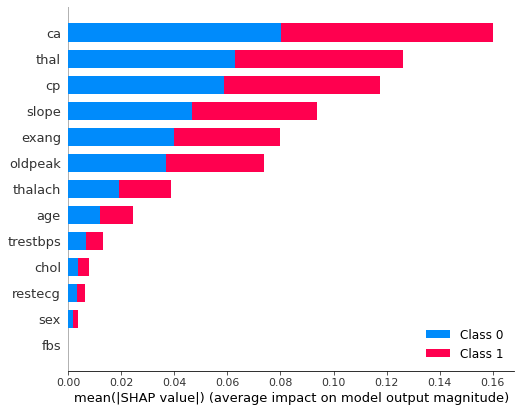

In [65]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

Permutation explainer: 304it [01:09,  3.89it/s]                                 
Permutation explainer: 101it [00:21,  2.47it/s]                                 


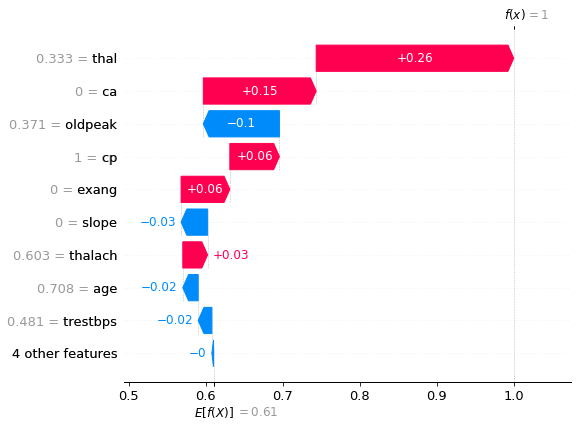

In [69]:
explainer = shap.Explainer(RFmod.predict, X) 

shap_values = explainer(X) # note this step mayu be long to run! below we sample on 100 elements only (notice time duration)
shap_values = explainer(X[:100]) 
shap.plots.waterfall(shap_values[0])

#### Explain the Waterefall
Referring to the docs: https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/waterfall.html
The waterfall plot shows how the shap values of the individual features are added to the base value in order to generate a final prediction.
"The bottom of the waterfall plot starts as the expected value of the model output E[f(x)]- here 0.6. 
Then each row shows how the positive (red) or negative (blue) contribution of each feature shifts this value from the expected model output over the background dataset to the model output for this prediction. Note this is a single prediction, hence the effect of a variable like - say - 'thal' (here it is ) can be seen globally using a scatter plot - as per ref. above - where we show the shap values versus tghe variable values - see plot below


NOTES:
- Note we passed just shap_values[0]. 
- Questioning additiviness & order of additions: if linear, it does not matter but if not...)

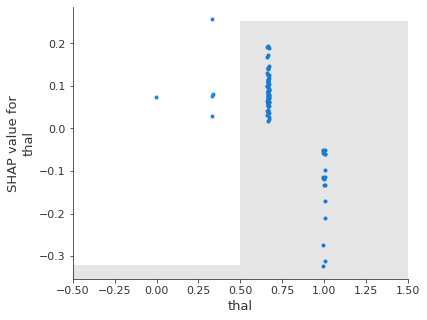

In [75]:
# scatter to show shap of the variable thal (thalassemia) versus its values 
# note thal is discrete - categorical 0 - see appendix - data dictionary
shap.plots.scatter(shap_values[:,"thal"])

Note that the values were standardized before training, but are reported in the same order (0, 0.375, 0.625, 1)

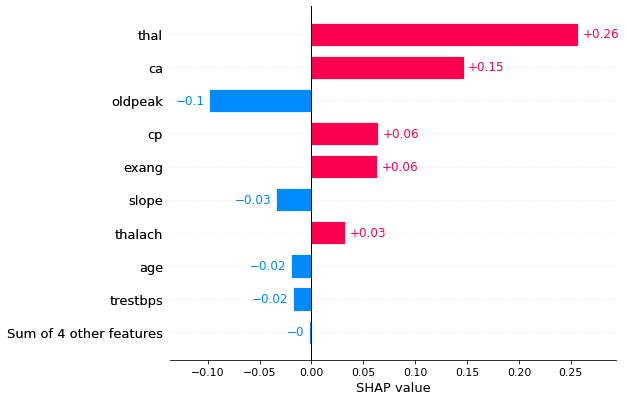

In [71]:
# The effect of all the variables on the prediction can be seen from the plot below, note that we used 

shap.plots.bar(shap_values[0])

### 9. Write/save model results 
(estimators metrics)

In [ ]:
# Use the same file path 
# In order to have the results always traceable, code a table or filename with: 
# - task: Regr, BiCl, MuCl (regression, binaryClassif, MultiClass)
# - dataset name - perhaps abbreviated? (ex. "wine", "rest", "energy", etc)
# - number of repetitions, k
# - name of original dataset

fnout= 'T_'+ tsk + '_' + str(k) + namef
fnout

'T_BiCl_2heart.csv'

In [28]:
# Write the file - the metr_df - as a csv
# might want to put a header with the settings
# also might want the models themselves? or the copy of the cell with the link to scikit - for repeatability?
# estim_stats.to_csv('~/Documents/Infra_py-ML/classif_data/'+fnout)

estim_stats.to_csv(fnout)


# [Could write the table in html format to be easily inputted to the report? take as next iteration modif)
# estim_stats.to_html(tbout +'.html')


## Appendices

#### Appendix 1 - Todo list
- Plot the ROC and show AUC
- plot learning curve
    But for these two simply use pycaret - see Pycaret verspon of the notebook - this repo

- package in a script

- Transform the notebook (Nb) for experimentation, not necessarily in this order:
    1. the Nb becomes a script where the input file will be acquired from the user --> handled by jupyter export (under the hood: nbconvert)
    2. the choice as whether to pre-select/eliminate some of the metrics depending on the task
    3. the pre-selection/cut of some of the estimators - e.g. select from a list

- dockerize - however, consider potential alternatives

#### Appendix 2 - Data dictionary

**Features**

 - age: The person’s age in years
 - sex: The person’s sex (1 = male, 0 = female)
 - cp: chest pain type
     - Value 0: asymptomatic
     - Value 1: atypical angina
     - Value 2: non-anginal pain
     - Value 3: typical angina
 - trestbps: The person’s resting blood pressure (mm Hg on admission to the hospital)
 - chol: The person’s cholesterol measurement in mg/dl
 - fbs: The person’s fasting blood sugar (> 120 mg/dl, 1 = true; 0 = false)
 - restecg: resting electrocardiographic results
     - Value 0: showing probable or definite left ventricular hypertrophy by Estes’ criteria
     - Value 1: normal
     - Value 2: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
 - thalach: The person’s maximum heart rate achieved
 - exang: Exercise induced angina (1 = yes; 0 = no)
 - oldpeak: ST depression induced by exercise relative to rest (‘ST’ relates to positions on the ECG plot. See more here)  
 - slope: the slope of the peak exercise ST segment 
      - 0: downsloping; 
      - 1: flat; 
      - 2: upsloping
 - ca: The number of major vessels (0–3)
 - thal: A blood disorder called thalassemia  (*)
    - Value 0: NULL (dropped from the dataset previously
    - Value 1: fixed defect (no blood flow in some part of the heart)
    - Value 2: normal blood flow
    - Value 3: reversible defect (a blood flow is observed but it is not normal)
 - target: Heart disease (1 = no, 0= yes)
 
 (*) thal: **CAREFUL** The coding at UCI website, 3 = normal; 6 = fixed defect; 7 = reversable defect is now in parentheses after each of the  values in the present dataset: we have 0 (NULL), 1 (ex. 6), 2 (ex. 3) ,3 (ex. 7)